`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   




# Лабораторная работа №3: Линейные модели. Кросс-валидация. 

*Модели*: множественная линейная регрессия 
*Данные*: `Boston_for_lab` (источник: <https://github.com/ania607/ML/blob/main/data/Boston_for_lab.csv>)

## Загружаем пакеты

In [47]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [48]:
# константы
#  ядро для генератора случайных чисел
my_seed = 5
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные

Набор данных `Boston_for_lab` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/ania607/ML/main/data/Boston_for_lab.csv>. 
Загружаем данные во фрейм и кодируем категориальные переменные.  

In [49]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/Boston_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (506, 15)


In [50]:
# первые 5 строк фрейма
DF_raw.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,tax_over_400
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,0


In [51]:
# типы столбцов фрейма
DF_raw.dtypes

crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rm              float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
black           float64
lstat           float64
medv            float64
tax_over_400      int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [52]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

crim            0
zn              0
indus           0
chas            0
nox             0
rm              0
age             0
dis             0
rad             0
tax             0
ptratio         0
black           0
lstat           0
medv            0
tax_over_400    0
dtype: int64

Пропусков не обнаружено.  

In [53]:
# оставляем в наборе данных только то, что нужно 
DF_raw = DF_raw[['medv', 'indus', 'crim', 'tax_over_400']]

DF_raw.columns

Index(['medv', 'indus', 'crim', 'tax_over_400'], dtype='object')

In [54]:
DF_raw.dtypes

medv            float64
indus           float64
crim            float64
tax_over_400      int64
dtype: object

Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [55]:
# данные для построения моделей
DF = DF_raw.sample(frac=0.8, random_state=my_seed)

# данные для прогнозов
DF_predict = DF_raw.drop(DF.index)

## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что переменная `medv`, которая является зависимой переменной модели, сильно отличается по масштабу от всех остальных

In [56]:
# описательные статистики для непрерывных переменных
DF[['medv', 'indus', 'crim']].describe()

,medv,indus,crim
count,405.000000,405.000000,405.000000
mean,22.537284,11.092667,3.515706
std,9.130293,6.953092,8.131135
min,5.000000,0.460000,0.006320
25%,16.800000,5.130000,0.078860
50%,21.100000,9.690000,0.251990
75%,25.100000,18.100000,3.673670
max,50.000000,27.740000,73.534100


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

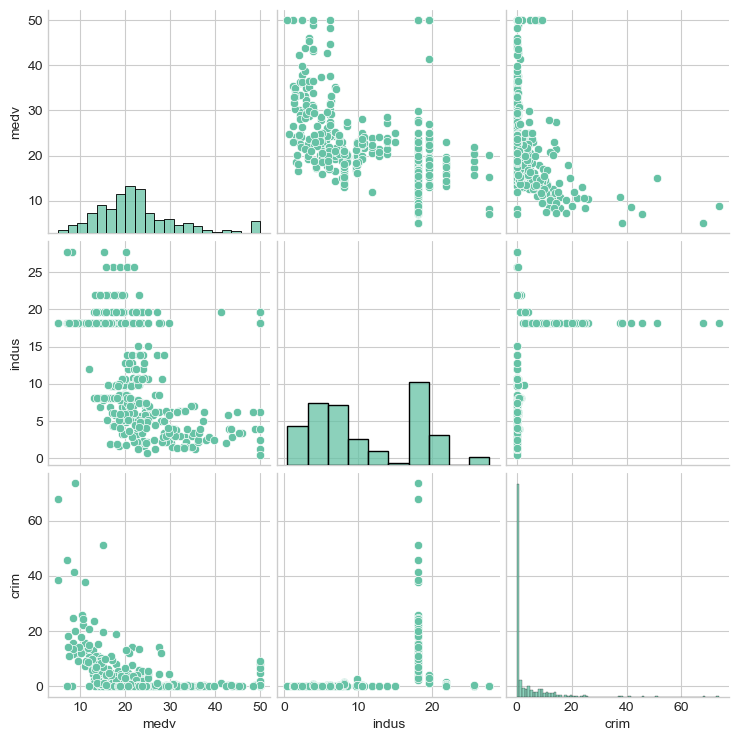

In [57]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['medv', 'indus', 'crim']])
plt.show()

Судя по этим графикам:  
* распределение зависимой `medv` является нормальным;  
* из всех объясняющих нет нормально распределённых;  

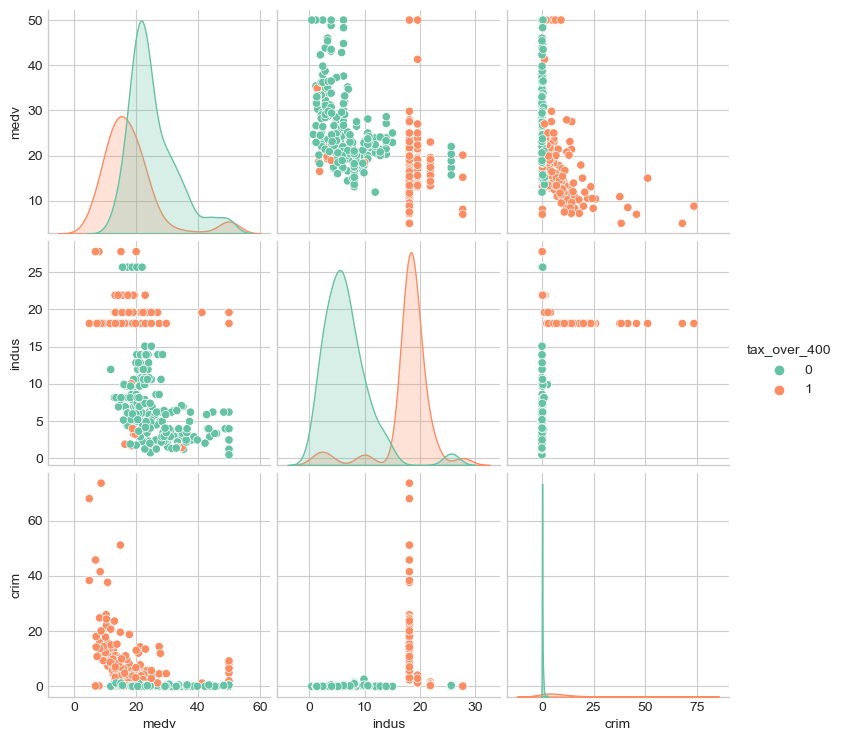

In [58]:
# матричный график разброса с цветом по tax_over_400
sns.pairplot(DF[['medv', 'indus', 'crim', 'tax_over_400']], hue='tax_over_400')
plt.show()

Посмотрим на корреляционные матрицы непрерывных переменных фрейма. 

In [59]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['medv', 'indus', 'crim']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

C:\Users\Andrew\AppData\Local\Temp\ipykernel_13304\3076736319.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,medv,indus,crim
medv,1.00,-0.46,-0.40
indus,-0.46,1.00,0.42
crim,-0.40,0.42,1.00


In [60]:
# корреляционная матрица по классу налога на имущество превышает 400
corr_mat = DF.loc[DF['tax_over_400']==1][['medv', 'indus', 'crim']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

C:\Users\Andrew\AppData\Local\Temp\ipykernel_13304\2324187948.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,medv,indus,crim
medv,1.00,-0.12,-0.36
indus,-0.12,1.00,0.08
crim,-0.36,0.08,1.00




### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [61]:
# логарифмируем зависимую переменную
DF['log_medv'] = np.log(DF['medv'])

# описательные статистики для непрерывных показателей
DF[['medv', 'log_medv', 'indus', 'crim']].describe()

,medv,log_medv,indus,crim
count,405.000000,405.000000,405.000000,405.000000
mean,22.537284,3.036458,11.092667,3.515706
std,9.130293,0.403275,6.953092,8.131135
min,5.000000,1.609438,0.460000,0.006320
25%,16.800000,2.821379,5.130000,0.078860
50%,21.100000,3.049273,9.690000,0.251990
75%,25.100000,3.222868,18.100000,3.673670
max,50.000000,3.912023,27.740000,73.534100


Проведём формальные тесты на нормальность.  

In [62]:
# тестируем на нормальность
for col in ['medv', 'log_medv']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

medv Statistics=0.92, p=0.0000
Распределение не нормально (H0 отклоняется)

log_medv Statistics=0.98, p=0.0000
Распределение не нормально (H0 отклоняется)



Логарифмирование меняет взаимосвязи между переменными.   

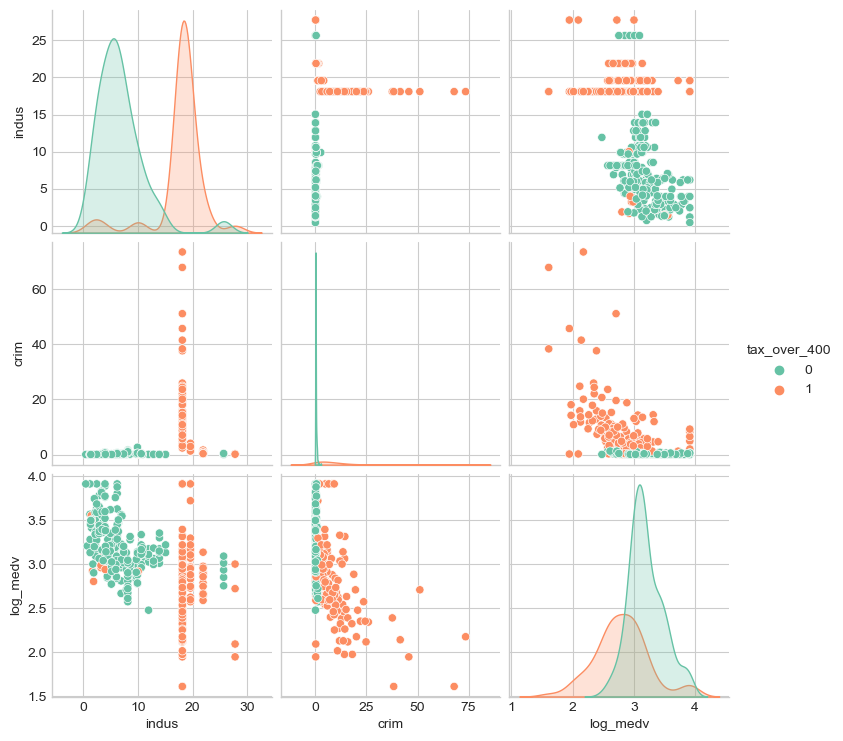

In [63]:
# матричный график разброса с цветом по tax_over_400
sns.pairplot(DF[['tax_over_400', 'indus', 'crim', 'log_medv']], hue='tax_over_400')
plt.show()

In [64]:
# корреляционная матрица по классу налога на имущество превышает 400
corr_mat = DF.loc[DF['tax_over_400']==1][['log_medv', 'indus', 'crim']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

C:\Users\Andrew\AppData\Local\Temp\ipykernel_13304\3140326713.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,log_medv,indus,crim
log_medv,1.00,-0.17,-0.51
indus,-0.17,1.00,0.08
crim,-0.51,0.08,1.00


In [65]:
# корреляционная матрица по классу налога на имущество не превышает 400
corr_mat = DF.loc[DF['tax_over_400']==0][['log_medv', 'indus', 'crim']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

C:\Users\Andrew\AppData\Local\Temp\ipykernel_13304\3145296532.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,log_medv,indus,crim
log_medv,1.00,-0.43,-0.24
indus,-0.43,1.00,0.14
crim,-0.24,0.14,1.00


## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot indus + \hat{\beta_3} \cdot crim$
1. `fit_lm_2`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot indus \cdot tax\_over\_400 + \hat{\beta_3} \cdot crim$
1. `fit_lm_3`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax\_over\_400 + \hat{\beta_2} \cdot crim \cdot tax\_over\_400 + \hat{\beta_3} \cdot indus$
1. `fit_lm_4`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax_over_400 + \hat{\beta_2} \cdot crim \cdot tax\_over\_400 + \hat{\beta_3} \cdot indus \cdot tax\_over\_400$

1. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_medv}$  
1. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_medv}$
1. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_medv}$
1. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_medv}$

Кроме того, добавим в сравнение модели зависимости `medv` и `log_medv` от всех объясняющих переменных: `fit_lm_0` и `fit_lm_0_log` соответственно. (9 и 10) 


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [66]:
# данные для моделей 1, 5
df1 = DF[['medv', 'tax_over_400', 'indus', 'crim']]

# данные для моделей 2, 6
df2 = DF[['medv', 'tax_over_400', 'indus', 'crim']]
df2.loc[:, 'indus_tax_over_400'] = df2.loc[:, 'indus'] * df2.loc[:, 'tax_over_400']
df2 = df2.drop(['indus'], axis=1)

# данные для моделей 3, 7
df3 = DF[['medv', 'tax_over_400', 'indus', 'crim']]
df3.loc[:, 'crim_tax_over_400'] = df3.loc[:, 'crim'] * df3.loc[:, 'tax_over_400']
df3 = df3.drop(['crim'], axis=1)

# данные для моделей 4, 8
df4 = DF[['medv', 'tax_over_400', 'indus', 'crim']]
df4.loc[:, 'indus_tax_over_400'] = df4.loc[:, 'indus'] * df4.loc[:, 'tax_over_400']
df4.loc[:, 'crim_tax_over_400'] = df4.loc[:, 'crim'] * df4.loc[:, 'tax_over_400']
df4 = df4.drop(['indus', 'crim'], axis=1)

# данные для моделей 9, 10
df0 = DF.drop(['log_medv'], axis=1)

In [67]:
# проверка результатов
df4.head()

,medv,tax_over_400,indus_tax_over_400,crim_tax_over_400
226,37.6,0,0.0,0.0000
292,27.9,0,0.0,0.0000
90,22.6,0,0.0,0.0000
373,13.8,1,18.1,11.1081
273,35.2,0,0.0,0.0000


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `medv` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [68]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [28.943] 
 объясняющие  ['indus', 'crim', 'tax_over_400'] 
 коэффициенты  [[-0.518 -0.287  0.886]]


In [69]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([7.81050951])

С интерпретацией модели на логарифме $Y$ дела обстоят сложнее:  
1. Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.  
1. Коэффициент при $X$ нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если $X$ увеличится на одну свою единицу измерения.  

In [70]:
# модель со всеми объясняющими, y_log
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [3.342] 
 объясняющие  ['indus', 'crim', 'tax_over_400'] 
 коэффициенты  [[-0.022 -0.02   0.008]]


In [71]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[-2.1, -2. ,  0.8]])

In [72]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([7.83151372])

In [73]:
print('MSE_train модели для medv меньше MSE_train',
     'модели для log(medv) в ', np.around(MSE_log / MSE, 3), 'раз')

MSE_train модели для medv меньше MSE_train модели для log(medv) в  [1.005] раз


### Оценка точности

#### LOOCV  

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

In [74]:
# LeaveOneOut CV
loo = LeaveOneOut()

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['medv'], axis=1)
    y = df.medv
    score = cross_val_score(lm, X, y, cv=loo,
                           scoring='neg_mean_squared_error').mean()    
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 20.12 секунд


In [75]:
df0.shape

(405, 4)

In [76]:
# модели для y_log
scores_log = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['medv'], axis=1)
    y = np.log(df.medv)
    score = cross_val_score(lm, X, y, cv=loo, n_jobs=1,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 15.37 секунд


Сравним ошибки для моделей на исходных значениях `medv` с ошибками моделей на логарифме.  

In [77]:
scores

[-62.15867773027466,
 -62.15867773027464,
 -67.13147862219516,
 -62.24751620538232,
 -67.25297210611556]

In [78]:
[np.around(-x, 2) for x in scores]

[62.16, 62.16, 67.13, 62.25, 67.25]

In [79]:
[np.around(-x, 3) for x in scores_log]

[0.098, 0.098, 0.106, 0.099, 0.107]

Определим самые точные модели отдельно на `charges` и на `log_charges`.  

In [80]:
# самая точная на medv
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_1 :
MSE_loocv = 62.0


In [81]:
# самая точная на log(medv)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_1_log :
MSE_loocv = 0.098


#### Перекрёстная проверка по блокам    

Теоретически этот метод менее затратен, чем LOOCV. Проверим на наших моделях.   

In [82]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['medv'], axis=1)
    y = df.medv
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.90 секунд


In [83]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['medv'], axis=1)
    y = np.log(df.medv)
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.80 секунд


In [84]:
scores

[-62.569604945070466,
 -62.3342633472938,
 -67.1960459272068,
 -62.08177186520176,
 -67.14747779127059]

In [85]:
# самая точная на medv
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_3 :
MSE_kf10 = 62.0


In [86]:
# самая точная на log(medv)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_1_log :
MSE_kf10 = 0.098


Можно убедиться, что оценка MSE методом перекрёстной проверки по 10 блокам даёт результаты, практически идентичные методу LOOCV

Самой точной среди моделей для `medv` оказалась `fit_lm_1` и ` fit_lm_3`, а среди моделей для `medv_log` – `fit_lm_1_log`. Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [87]:
# прогноз по fit_lm_3
#  модель на всех обучающих наблюдениях
X = df3.drop(['medv'], axis=1)
y = df3.medv.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['medv']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)
#  прогнозы
y_pred = fit_lm_3.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_3 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_3 на отложенных наблюдениях = 376.32


c:\Users\Andrew\anaconda3\envs\new\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- crim
Feature names seen at fit time, yet now missing:
- crim_tax_over_400

  warnings.warn(message, FutureWarning)


In [88]:
# прогноз по fit_lm_1
#  модель на всех обучающих наблюдениях
X = df1.drop(['medv'], axis=1)
y = df1.medv.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['medv']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)
#  прогнозы
y_pred = fit_lm_1.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_1 на отложенных наблюдениях = %.2f' % MSE)


MSE модели fit_lm_1 на отложенных наблюдениях = 352.95


c:\Users\Andrew\anaconda3\envs\new\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [89]:
# прогноз по fit_lm_1_log
# модель
X = df1.drop(['medv'], axis=1)
y = np.log(df1.medv).values.reshape(-1, 1)
fit_lm_1_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['medv']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_1_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_1_log на отложенных наблюдениях = 116.05


c:\Users\Andrew\anaconda3\envs\new\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [90]:
np.sqrt(MSE_log) / np.mean(DF_predict[['medv']]) * 100

c:\Users\Andrew\anaconda3\envs\new\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


medv    47.847561
dtype: float64

In [91]:
np.sqrt(MSE) / np.mean(DF_predict[['medv']]) * 100

c:\Users\Andrew\anaconda3\envs\new\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


medv    83.44222
dtype: float64

На выборке для прогноза точнее модель `fit_lm_3`

In [92]:
X = df1.drop(['medv'], axis=1)
y = df1.medv.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)

print('модель fit_lm_1:\n', 
      'константа ', np.around(fit_lm_1.intercept_, 3),
      '\n объясняющие ', list(df1.drop(['medv'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_1.coef_, 3))

модель fit_lm_1:
 константа  [28.943] 
 объясняющие  ['tax_over_400', 'indus', 'crim'] 
 коэффициенты  [[ 0.886 -0.518 -0.287]]
